# Understanding time-series models and random walks?
In this case, we will explore the futile, but valiant effort of predicting BitCoin prices through both an LSTM network as well as random walks.

Using a dataset that records daily prices, rather than minute by minute prices, we can avoid noise leading to inconclusive results.

In [32]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import numpy as np

# get market info for bitcoin from the start of 2016 to the current day
bitcoin_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
bitcoin_info = bitcoin_info.assign(Date=pd.to_datetime(bitcoin_info['Date']));

#Cleanup dataset when volume is equal to -; asteriks in column names, and volume needs to be an int
bitcoin_info.loc[bitcoin_info['Volume']=="-",'Volume']=0
bitcoin_info.columns = bitcoin_info.columns.str.replace("*",""); #columns is an array of column labels
bitcoin_info['Volume'] = bitcoin_info['Volume'].astype('int64');


bitcoin_info.columns =[bitcoin_info.columns[0]]+['bt_'+i for i in bitcoin_info.columns[1:]] #column names not mutable
bitcoin_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap
0,2018-10-24,6478.89,6521.99,6468.86,6495.84,3424670000,112334356277
1,2018-10-23,6472.36,6506.01,6451.27,6475.74,3716150000,112208672191
2,2018-10-22,6486.05,6543.80,6462.98,6487.16,3672860000,112433242751
3,2018-10-21,6490.09,6556.38,6476.00,6482.35,3253610000,112492164597
4,2018-10-20,6460.92,6497.72,6449.00,6489.19,3379130000,111975104604


Lets Plot the Opening Price over Time

Text(0.5,1,'Bitcoin Closing Price Over Time')

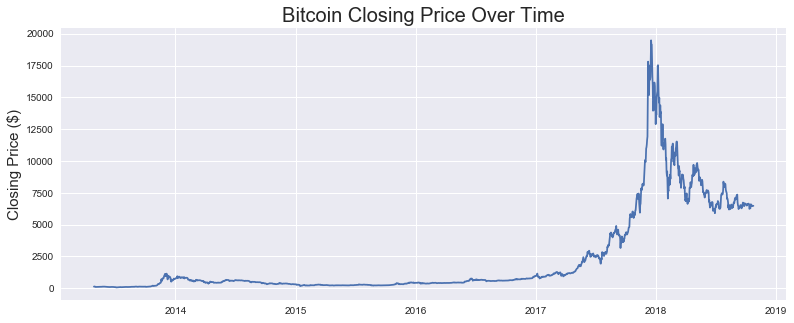

In [33]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(13)
mpl.style.use('seaborn')
plt.plot(bitcoin_info['Date'].astype(datetime.datetime),bitcoin_info['bt_Open'])
plt.ylabel('Closing Price ($)',fontsize=15)
plt.title('Bitcoin Closing Price Over Time',fontsize=20)

In [34]:
bitcoin_info_split =bitcoin_info[bitcoin_info['Date']>='2015-01-01']
bitcoin_info = bitcoin_info_split.assign(bt_day_norm_diff = lambda x:(x['bt_Close']- x['bt_Open'])/x['bt_Open'])
bitcoin_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,bt_day_norm_diff
0,2018-10-24,6478.89,6521.99,6468.86,6495.84,3424670000,112334356277,0.002616
1,2018-10-23,6472.36,6506.01,6451.27,6475.74,3716150000,112208672191,0.000522
2,2018-10-22,6486.05,6543.80,6462.98,6487.16,3672860000,112433242751,0.000171
3,2018-10-21,6490.09,6556.38,6476.00,6482.35,3253610000,112492164597,-0.001193
4,2018-10-20,6460.92,6497.72,6449.00,6489.19,3379130000,111975104604,0.004376


Let us now mark the data which data the model will be trained on prior and tested on after. Arbitraily, I will pick the 1st of June 2017 as that data.

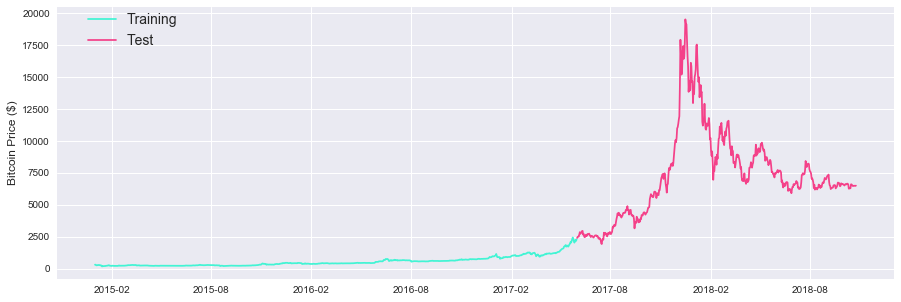

In [35]:
split = '2017-06-01'
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
mpl.style.use('seaborn')
plt.plot(bitcoin_info[bitcoin_info['Date'] < split]['Date'].astype(datetime.datetime),
         bitcoin_info[bitcoin_info['Date'] < split]['bt_Close'], 
         color='#42f4d4', label='Training')
plt.plot(bitcoin_info[bitcoin_info['Date'] >= split]['Date'].astype(datetime.datetime),
         bitcoin_info[bitcoin_info['Date'] >= split]['bt_Close'], 
         color='#f44189', label='Test')
plt.ylabel('Bitcoin Price ($)',fontsize=12)
plt.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})

The simplest walk can be described as a lag model, in other words, today's price will equal yesterday's price. How exciting!

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x1f22a1b2cc0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x1f22a1e3198>)

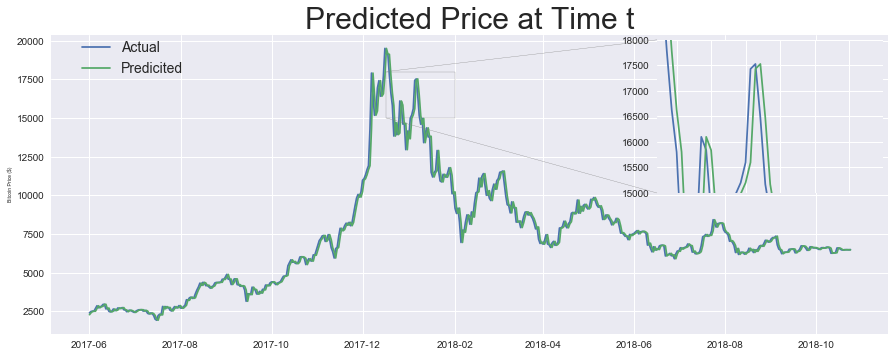

In [36]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(15)
mpl.style.use('seaborn')
ax.plot(bitcoin_info[bitcoin_info['Date']>=split]['Date'].astype(datetime.datetime),
        bitcoin_info[bitcoin_info['Date']>=split]['bt_Close'],label='Actual')
current_date = datetime.datetime.strptime(split,'%Y-%m-%d')
ax.plot(bitcoin_info[bitcoin_info['Date']>=split]['Date'].astype(datetime.datetime),
        bitcoin_info[bitcoin_info['Date']>=current_date-datetime.timedelta(days=1)]['bt_Close'][1:],label='Predicited')

ax.set_ylabel('Bitcoin Price ($)',fontsize=20)
ax.set_title('Predicted Price at Time t',fontsize = 30)
plt.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})

#ZOom! This code is from http://akuederle.com/matplotlib-zoomed-up-inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axins = zoomed_inset_axes(ax, 3.3, loc=1) # zoom-factor: 2.5, location: upper-left
axins.plot(bitcoin_info[bitcoin_info['Date']>=split]['Date'].astype(datetime.datetime),
        bitcoin_info[bitcoin_info['Date']>=split]['bt_Close'])
current_date = datetime.datetime.strptime(split,'%Y-%m-%d')
axins.plot(bitcoin_info[bitcoin_info['Date']>=split]['Date'].astype(datetime.datetime),
        bitcoin_info[bitcoin_info['Date']>=current_date-datetime.timedelta(days=1)]['bt_Close'][1:])
ax.set_ylabel('Bitcoin Price ($)',fontsize=5)
axins.set_xlim(datetime.date(2017,12,17), datetime.date(2018,2,1)) # apply the x-limits
axins.set_ylim(15000,18000) # apply the y-limits
plt.xticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

## Random Walks
As we can see, nobody is going to be a billionaire overnight through this method. Instead of mirroring prices, let us try using 
random walks. Except, what is a random walk? For that, let us start with a example I've taken from a PBS Studio Video (https://www.youtube.com/watch?v=stgYW6M5o4k)

Imagine that on flipping a fair coin, a head represents moving foward one spot on the number line while a tail represents moving backward one spot on the number line. We can say that after one flip, you can have either H or T; thus,there is a 1/2 probability of being at 1 and a 1/2 probability of being at -1. In two turns, you can flip either HH, TT, HT or TH; thus there is a 1/4 probability at being -2,1/4 probability being at 2, and 1/2 probability being at 0. In three turns, you can flip either HHH, TTT, HTH, THT, HHT, THH, TTH, HTT; thus there is a 1/8 probability at being -3,3/8 probability being at -1, 3/8 probability being at 1, and 1/8 probability being at 3.

We can enumerate the results for n flips as follows: 

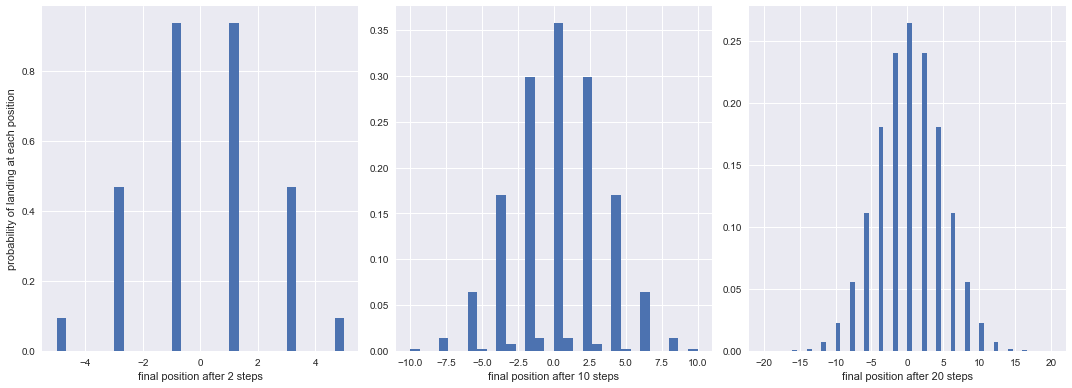

In [37]:
def tosses(N):
    L = [''] 
    for i in range(0,N):
        L=[l+'H' for l in L]+[l+'T' for l in L]
    return L
list=[]
count = 0
def make_freq(N):
    count = 0
    toss_enumeration = tosses(N)
    for combo in toss_enumeration:
        for i in range(len(combo)):
            if combo[i]=='H':
                count+=1
            else:
                count-=1
        list.append(count);
        count = 0;
    

make_freq(5)
pd_list = pd.Series(list)
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.hist(pd_list,bins =30,density = True)
ax1.set_xlabel("final position after 2 steps")
ax1.set_ylabel("probability of landing at each position")

make_freq(10)
pd_list = pd.Series(list)
ax2.hist(pd_list,bins =30,density = True)
ax2.set_xlabel("final position after 10 steps")


make_freq(20)
pd_list = pd.Series(list)
ax3.hist(pd_list,bins =60,density = True)
ax3.set_xlabel("final position after 20 steps")

fig.set_figwidth(15)
plt.tight_layout()

As you can see after N flips, the probabilites of landing further from 0 get smaller as N increases. In fact, you will land between $-\sqrt{N}$ and $\sqrt{N}$ most of the time.

### Lets Get back to BitCoin now

Therefore, if we treat a quantity such as prices as random walks, then: 
$PredictedPrice_t = ActualPrice_{t-1} * X$~$N(\mu,\sigma)$ where $\mu$ and $\sigma$ are determined before the split date

First, we check if the normalized price differences follow a normal distribution.

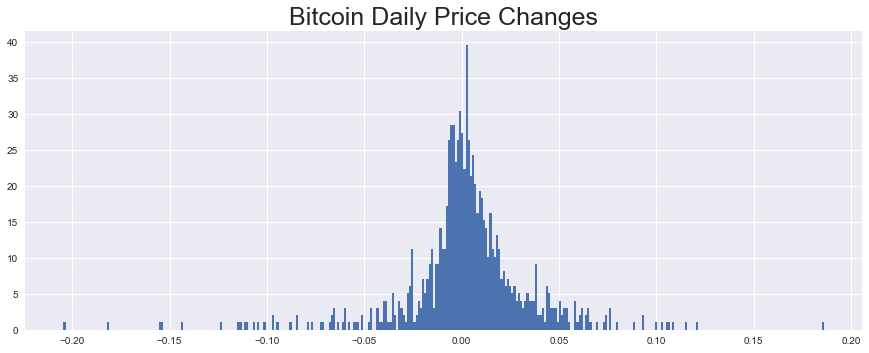

In [38]:
fig, (ax1) = plt.subplots(1,1)
fig.set_figwidth(15)
ax1.hist(bitcoin_info[bitcoin_info['Date']< split]['bt_day_norm_diff'], density = True, bins=350)
ax1.set_title('Bitcoin Daily Price Changes',fontsize = 25)
plt.show()

Next, we graph a model based on single-point prediction and multi-pont prediction of the test set. Although the single-point predictions are quite accurate, there is no real prediction power just as we saw with the simple lag model above.
Play with the slider to see how dependent the models are on random seed, especially on the full interval prediction.

In [39]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
def plt_bt_single(seed):
    np.random.seed(seed)
    bt_walk_mean = np.mean(bitcoin_info[bitcoin_info['Date']<split]['bt_day_norm_diff'])
    bt_walk_std = np.std(bitcoin_info[bitcoin_info['Date']<split]['bt_day_norm_diff'])
    bt_random_steps = np.random.normal(bt_walk_mean, bt_walk_std,
                                       (max(bitcoin_info['Date']).to_pydatetime() - datetime.datetime.strptime(split, '%Y-%m-%d')).days + 1)
    bt_random=[]
    #value is the counter-th representation in bt_random_steps
    #add each closing price*(multiple of value(use training data)) to the bt_random array and 
    # append using the previous days adjusted price to the current day*next value
    for counter, value in enumerate(bt_random_steps):
        if counter==0:
            #set the intial price
            bt_random.append(bitcoin_info[bitcoin_info['Date']< split]['bt_Close'].values[0]*(1+value))
        else:
            bt_random.append(bt_random[counter-1]*(value+1))
            
    
    fig, (ax1,ax2) =plt.subplots(2,1)
    #graph using test data
    ax1.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'].astype(datetime.datetime),
         bitcoin_info[bitcoin_info['Date']>= split]['bt_Close'], label='Actual')
    ax1.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'].astype(datetime.datetime),
         bitcoin_info[bitcoin_info['Date'] + datetime.timedelta(days=1)>= split]['bt_Close'][1:] * (1+bt_random_steps), label='Predicted')
    
    ax2.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'].astype(datetime.datetime),
         bitcoin_info[bitcoin_info['Date']>= split]['bt_Close'], label='Actual')
    ax2.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'].astype(datetime.datetime),
         bt_random[::-1], label='Predicted')
    
    
    #Zoom
    axins = zoomed_inset_axes(ax1, 2.2, loc=1) # zoom-factor: 2.2, location: upper-right
    axins.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'].astype(datetime.datetime),
         bitcoin_info[bitcoin_info['Date']>= split]['bt_Close'], label='Actual')
    axins.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'].astype(datetime.datetime),
         bitcoin_info[bitcoin_info['Date'] + datetime.timedelta(days=1)>= split]['bt_Close'][1:] * (1+bt_random_steps), label='Predicted')
    axins.set_xlim(datetime.date(2018,2,1), datetime.date(2018,4,1)) # apply the x-limits
    axins.set_ylim(6500,12000) # apply the y-limits
    
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    #somehow figure out a zoom only where collisions occur
    
    
    #Graph stuff
    ax1.set_ylabel('Bitcoin Price ($)',fontsize=20)
    ax1.set_title('Single Point Random Walk',fontsize=30)
    ax2.set_title('Full Interval Random Walk',fontsize=30)
    fig.set_figwidth(15)
    fig.set_figheight(10)
    plt.legend(bbox_to_anchor=(0.03, 1), loc=1, borderaxespad=0., prop={'size': 14})
   
            
    plt.show()
    
interactive_plot = interactive(plt_bt_single, seed=(0,100),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=50, description='seed'), Output(layout=Layout(height='350px'))), _dom_cl…

As we can see from each type of walk, a crucial sticker is that we trained over a period (2014-2016) where the price was relatively stagnant.

# LSTM (Long Short Term Memory)

Let's see if the magic of neural network can offer any real prediction power. 
Past performance always implies future performance, right?

Some new columns we will add are volatility and and a close price/ high price difference.
    Volatility is a very complicated topic [example](https://core.ac.uk/download/pdf/111421957.pdf) with many different definitions including "opening, closing, high and low prices", drift, and other mathmatical models. For our cases, volatility is simply the difference between high and low price divided by the opening price.
    The bt_close_high_diff is the difference between the closing price and price high, but calculated such that 1 equals the daily high and -1 equals the daily low.

Next, we must normalize our data so that no input feature dominates the model.

In [40]:
#following defintion of volatility
bitcoin_info = bitcoin_info.assign(bt_day_volatility = lambda x:(x['bt_High']- x['bt_Low'])/x['bt_Open'])
#
bitcoin_info = bitcoin_info.assign(bt_close_high_diff = lambda x:2*(x['bt_High']- x['bt_Close'])/(x['bt_High']-x['bt_Low'])-1)
#print(bitcoin_info[bitcoin_info['bt_close_high_diff']==1])
bitcoin_info = bitcoin_info.sort_values(by='Date')
bitcoin_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,bt_day_norm_diff,bt_day_volatility,bt_close_high_diff
1392,2015-01-01,320.43,320.43,314.00,314.25,8036550,4380819968,-0.019287,0.020067,0.922240
1391,2015-01-02,314.08,315.84,313.57,315.03,7860650,4295209984,0.003025,0.007227,-0.286344
1390,2015-01-03,314.85,315.15,281.08,281.08,33054400,4307010048,-0.107257,0.108210,1.000000
1389,2015-01-04,281.15,287.23,257.61,264.20,55629100,3847150080,-0.060288,0.105353,0.555030
1388,2015-01-05,265.08,278.34,265.08,274.47,43962800,3628489984,0.035423,0.050023,-0.416290


We purpose pick a neuron to be a collection of 10 days. Whether that is too long a time period for prediction or even too short a time period depends on if you believe the EMH. Furthermore, columns like bt_Market_Cap,bt_day_norm_diff, bt_Open, Date, bt_Low, bt_High are unnescessary now. 

In [41]:
training_set = bitcoin_info[bitcoin_info['Date']<split]
test_set = bitcoin_info[bitcoin_info['Date']>=split]
def drop(set):
    set = set.drop('Date', 1)
    set = set.drop('bt_Open',1)
    set = set.drop('bt_Market Cap', 1)
    set = set.drop('bt_Low', 1)
    set = set.drop('bt_High', 1)
    set = set.drop('bt_day_norm_diff',1)
    return set
training_set = drop(training_set)
test_set = drop(test_set)

training_input_neurons=[]
test_input_neurons=[]
for i in range(len(training_set)-10):
    #every 10th dataframe of the training set
    every_10th_set = training_set[i:(i+10)].copy()
    for col in ['bt_Close','bt_Volume']:
        #normalize!
        every_10th_set.loc[:, col] = every_10th_set[col]/every_10th_set[col].iloc[0] - 1 
    training_input_neurons.append(every_10th_set);
    
for i in range(len(test_set)-10):
    every_10th_set = test_set[i:(i+10)].copy()
    for col in ['bt_Close','bt_Volume']:
        #normalize!
        every_10th_set.loc[:, col] = every_10th_set[col]/every_10th_set[col].iloc[0] - 1
    test_input_neurons.append(every_10th_set)
    
display(training_input_neurons[0])
display(test_input_neurons[0])

,bt_Close,bt_Volume,bt_day_volatility,bt_close_high_diff
1392,0.000000,0.000000,0.020067,0.922240
1391,0.002482,-0.021888,0.007227,-0.286344
1390,-0.105553,3.113009,0.108210,1.000000
1389,-0.159268,5.922013,0.105353,0.555030
1388,-0.126587,4.470357,0.050023,-0.416290
1387,-0.089292,1.892497,0.054077,-0.816835
1386,-0.063357,2.094213,0.054775,-0.437141
1385,-0.098329,1.486453,0.040695,0.802840
1384,-0.075863,1.329184,0.037467,-0.867675
1383,-0.125537,0.899360,0.049286,0.882768


,bt_Close,bt_Volume,bt_day_volatility,bt_close_high_diff
510,0.000000,0.000000,0.069946,-0.493815
509,0.033503,-0.203335,0.047932,-1.000000
508,0.044633,-0.083615,0.063496,-0.159278
507,0.043162,-0.180295,0.052339,0.111061
506,0.115840,-0.171712,0.070287,-1.000000
505,0.189096,0.263994,0.114860,-0.115346
504,0.134674,-0.081945,0.058835,0.625637
503,0.165183,-0.225027,0.053060,-0.865882
502,0.172737,-0.184027,0.037789,0.468564
501,0.224193,0.221216,0.072288,-0.967912


In [147]:
training_input_neurons = [np.array(training_input_neuron) for training_input_neuron in training_input_neurons]
training_input_neurons = np.array(training_input_neurons)

test_input_neurons = [np.array(test_input_neuron) for test_input_neuron in test_input_neurons]
test_input_neurons = np.array(test_input_neurons)
#need .values or it will NaN
training_outputs = (training_set['bt_Close'][10:].values/training_set['bt_Close'][:-10].values)-1
test_outputs = (test_set['bt_Close'][10:].values/test_set['bt_Close'][:-10].values)-1

In [75]:
display(training_outputs)

array([-1.54622116e-01, -1.49922230e-01, -1.96456525e-01, -3.25889478e-01,
       -2.35472001e-01, -2.72860687e-01, -3.23027791e-01, -2.57667196e-01,
       -2.60149444e-01, -2.31004367e-01, -1.45900775e-01, -1.28416729e-01,
        3.10812007e-02,  3.91633914e-01,  2.09111704e-01,  3.14127823e-01,
        3.22292482e-01,  1.12056670e-01,  8.68007074e-02,  7.15029339e-02,
       -4.16042309e-02, -2.75909344e-02,  2.29732051e-02, -8.30340932e-02,
       -1.05904146e-01, -2.06092076e-01, -1.56406558e-01, -2.63349151e-02,
       -4.32529656e-02, -2.79114958e-02,  1.09445415e-02, -3.43217165e-02,
       -6.91348697e-02,  3.59044309e-02,  1.34317831e-01,  8.15715536e-02,
        5.20538084e-02,  6.96377607e-02,  5.78308939e-02,  9.16360002e-02,
        1.08897380e-01,  1.15658363e-01,  6.41233766e-02,  1.46965128e-02,
       -7.22058138e-02,  1.12852398e-02,  1.10759494e-02,  4.19523008e-02,
        7.58684890e-02,  8.29032795e-02,  1.30814669e-01,  1.52005889e-01,
        1.57259090e-01,  

[What is Dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

In [46]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
def LSTM_model(data, output_size, neurons):
    #if we didn't have the test and training data split up, scikit has a cool train_test_split function
    model = Sequential()
    model.add(LSTM(neurons,input_shape=(data.shape[1],data.shape[2])))
    #activation of 'downstream' neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.
    model.add(Dropout(.25))
    model.add(Dense(units=1))
    model.add(Activation("linear"))
    model.compile(loss="mae", optimizer="adam")
    return model


In [49]:
bt_model = LSTM_model(training_input_neurons,1,20)
#train, finally!!!
# Stochastic Batch Gradient Descent????
bt_error_epoch = bt_model.fit(training_input_neurons,training_outputs,epochs=50, batch_size=1,verbose=2,shuffle=True)

Epoch 1/50
 - 5s - loss: 0.0556
Epoch 2/50
 - 4s - loss: 0.0356
Epoch 3/50
 - 4s - loss: 0.0314
Epoch 4/50
 - 4s - loss: 0.0301
Epoch 5/50
 - 4s - loss: 0.0284
Epoch 6/50
 - 4s - loss: 0.0272
Epoch 7/50
 - 4s - loss: 0.0265
Epoch 8/50
 - 4s - loss: 0.0267
Epoch 9/50
 - 4s - loss: 0.0259
Epoch 10/50
 - 4s - loss: 0.0254
Epoch 11/50
 - 4s - loss: 0.0255
Epoch 12/50
 - 4s - loss: 0.0254
Epoch 13/50
 - 4s - loss: 0.0248
Epoch 14/50
 - 4s - loss: 0.0249
Epoch 15/50
 - 4s - loss: 0.0250
Epoch 16/50
 - 4s - loss: 0.0249
Epoch 17/50
 - 4s - loss: 0.0249
Epoch 18/50
 - 4s - loss: 0.0239
Epoch 19/50
 - 4s - loss: 0.0244
Epoch 20/50
 - 4s - loss: 0.0245
Epoch 21/50
 - 4s - loss: 0.0244
Epoch 22/50
 - 4s - loss: 0.0237
Epoch 23/50
 - 4s - loss: 0.0242
Epoch 24/50
 - 4s - loss: 0.0234
Epoch 25/50
 - 4s - loss: 0.0238
Epoch 26/50
 - 4s - loss: 0.0237
Epoch 27/50
 - 4s - loss: 0.0235
Epoch 28/50
 - 4s - loss: 0.0237
Epoch 29/50
 - 4s - loss: 0.0241
Epoch 30/50
 - 4s - loss: 0.0240
Epoch 31/50
 - 4s -

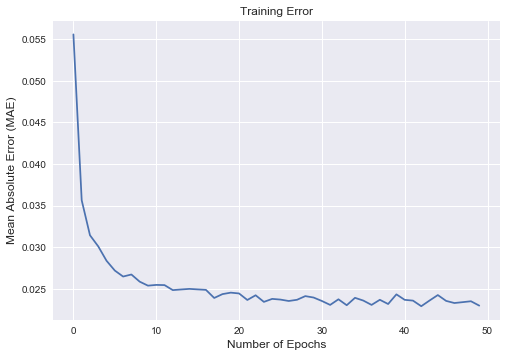

In [140]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(bt_error_epoch.epoch, bt_error_epoch.history['loss'])
ax1.set_title('Training Error')

ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)

ax1.set_xlabel('Number of Epochs',fontsize=12)
plt.show()

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x1f23c510f28>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x1f23c528be0>)

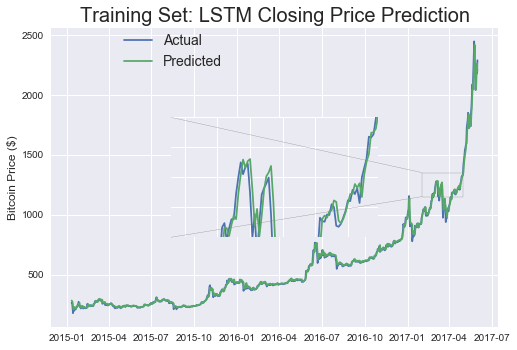

In [144]:
fig, ax1 = plt.subplots(1,1)
#1392 rows as of 10/24
ax1.plot(bitcoin_info[bitcoin_info['Date']< split]['Date'][10:].astype(datetime.datetime),
         training_set['bt_Close'][10:], label='Actual')
#prediction will give normalized closing prices, so have to 'undo' that
#print(bt_model.predict(training_input_neurons))
#print((((np.transpose(bt_model.predict(training_input_neurons))+1)* training_set['bt_Close'].values[:-10])[0]))
#why do i need [0]??
ax1.plot(bitcoin_info[bitcoin_info['Date']< split]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(training_input_neurons))+1)* training_set['bt_Close'].values[:-10])[0], label='Predicted')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Training Set: LSTM Closing Price Prediction',fontsize=20)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)

axins = zoomed_inset_axes(ax1, 5, loc=10)
axins.plot(bitcoin_info[bitcoin_info['Date']< split]['Date'][10:].astype(datetime.datetime),
         training_set['bt_Close'][10:], label='Actual')
axins.plot(bitcoin_info[bitcoin_info['Date']< split]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(training_input_neurons))+1)* training_set['bt_Close'].values[:-10])[0], label='Predicted')

axins.set_xlim(datetime.date(2017,2,1), datetime.date(2017,5,1)) # apply the x-limits
axins.set_ylim(1150,1350) # apply the y-limits
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax1, axins, loc1=2, loc2=3, fc="none", ec="0.5")

Know that we've seen graphs of predictions closely mirroing the actual results, we should be wary of this result. This is the result for the training set...we could have overfit our data(hopefully Dropout lessened this impact). Let's see if we did through plotting the test data!

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x1f23ea7ccc0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x1f23ea8beb8>)

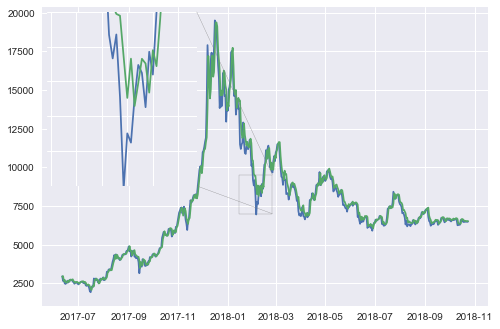

In [175]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'][10:].astype(datetime.datetime),
         test_set['bt_Close'][10:], label='Actual')
ax1.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(test_input_neurons))+1)* test_set['bt_Close'].values[:-10])[0], label='Predicted')

axins = zoomed_inset_axes(ax1, 4.5, loc=2)
axins.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'][10:].astype(datetime.datetime),
         test_set['bt_Close'][10:], label='Actual')
axins.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(test_input_neurons))+1)* test_set['bt_Close'].values[:-10])[0], label='Predicted')
axins.set_xlim(datetime.date(2018,1,15), datetime.date(2018,2,25)) # apply the x-limits
axins.set_ylim(7000,9500) # apply the y-limits
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax1, axins, loc1=1, loc2=4, fc="none", ec="0.5")

For a single point prediction where each price is normalized to every 10th closing price, the model performs quite well. However, similar to random walks, the model is sensitive to random seed. And now we can even calculate error between the two diffrent methods of prediction.

Just as we did with the random walk, a full interval prediction can be modeled where the next $n$ prices are normalized to every 10th closing price. //TODO